In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
n_samples, h, w = lfw_people.images.shape

In [4]:
X = lfw_people.data

In [5]:
n_features = X.shape[1]

In [6]:
y = lfw_people.target
target_names = lfw_people.target_names

In [7]:
n_classes = target_names.shape[0]

In [8]:
pca = RandomizedPCA(n_components=150, whiten=True,svd_solver='randomized', random_state=42)

In [9]:
svc = SVC(kernel='rbf', class_weight='balanced')

In [10]:
model = make_pipeline(pca,svc)
print(model)

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(class_weight='balanced'))])


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
param_grid = {'svc__C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(model, param_grid)

In [13]:
clf = clf.fit(X_train,y_train)

In [14]:
clf.best_estimator_

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=1000.0, class_weight='balanced', gamma=0.005))])

In [15]:
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.85       322
        macro avg       0.90      0.73      0.79       322
     weighted avg       0.87      0.85      0.85       322



In [17]:
def plot_gallery(images, titles, h, w, n_row=4, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        pred_name,true_name = titles[i]
        title = 'predicted: %s\ntrue: %s' % (pred_name, true_name)
        col = 'k' if pred_name == true_name else 'r'
        title_obj = plt.title(title, size=12)
        plt.setp(title_obj, color = col)
        plt.xticks(())
        plt.yticks(())

In [18]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return (pred_name,true_name)

In [19]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

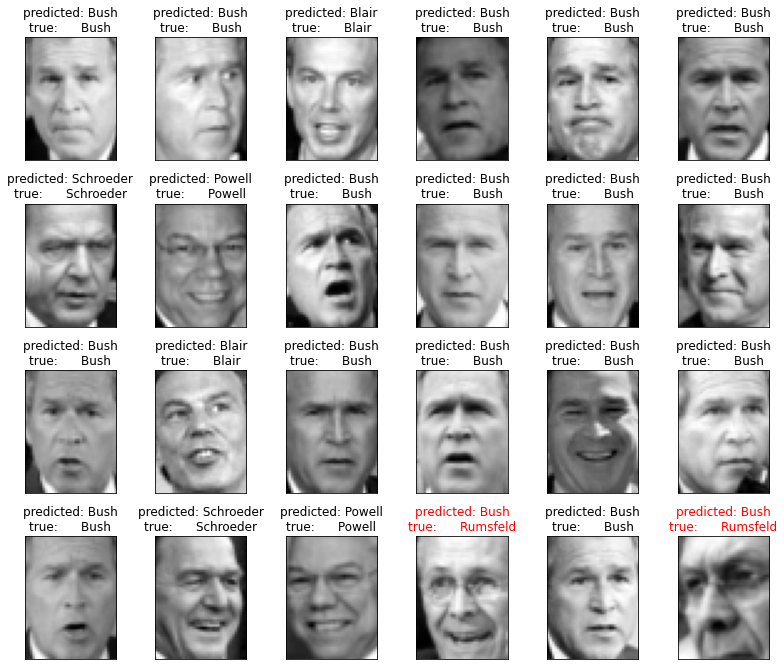

In [20]:
plot_gallery(X_test, prediction_titles, h, w)

In [21]:
df = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})

In [22]:
df['result'] = np.where(df['y_test'] == df['y_pred'], 1, 0)

In [23]:
confusion_matrix = pd.crosstab(df['y_pred'], df['y_test'], rownames=['Predicted'], colnames=['Actual'])

In [24]:
confusion_matrix

Actual,0,1,2,3,4,5,6
Predicted,,,,,,,
0,7,1,1,0,0,0,0
1,1,52,2,3,1,3,1
2,0,0,17,0,0,0,1
3,5,7,7,143,3,4,5
4,0,0,0,0,20,1,0
5,0,0,0,0,0,7,0
6,0,0,0,0,1,0,29


In [25]:
heatmap_data = pd.pivot_table(df, values='result', 
                     index=['y_pred'], 
                     columns='y_test')

<AxesSubplot:xlabel='y_test', ylabel='y_pred'>

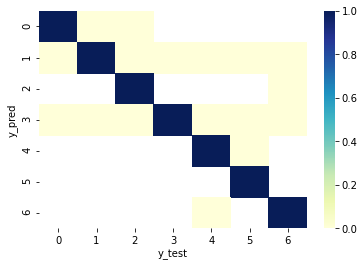

In [26]:
sbn.heatmap(heatmap_data, cmap="YlGnBu")